In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

tsdm_df = pd.read_csv('Datasets/tsdm.csv')

tsdm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3691 entries, 0 to 3690
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PADDOCK_ID          3691 non-null   object 
 1   OBSERVATION_DATE    3691 non-null   object 
 2   TSDM                3691 non-null   float64
 3   15D_AVG_DAILY_RAIN  3691 non-null   float64
 4   15D_AVG_MAX_TEMP    3691 non-null   float64
 5   15D_AVG_MIN_TEMP    3691 non-null   float64
 6   15D_AVG_RH_TMAX     3691 non-null   float64
 7   15D_AVG_RH_TMIN     3691 non-null   float64
 8   15D_AVG_EVAP_SYN    3691 non-null   float64
 9   15D_AVG_RADIATION   3691 non-null   float64
dtypes: float64(8), object(2)
memory usage: 288.5+ KB


In [4]:
print(tsdm_df['OBSERVATION_DATE'])

0       2017-02-04
1       2017-02-19
2       2017-03-06
3       2017-03-21
4       2017-04-05
           ...    
3686    2024-10-25
3687    2024-11-09
3688    2024-11-24
3689    2024-12-09
3690    2024-12-24
Name: OBSERVATION_DATE, Length: 3691, dtype: object


In [ ]:
#preprocessing

tsdm_df['OBSERVATION_DATE'] = pd.to_datetime(tsdm_df['OBSERVATION_DATE'])

In [ ]:
def create_sequences(sequence, lookback, forecast_horizon, target_col):

    T, num_features = sequence.shape
    X, y, lengths = [], [], []
    #pre-pad shorter sequences to a fixed length
    pad_vector = np.zeros((lookback, num_features))

        # loops over each time step
    for t in range(1, T - forecast_horizon + 1):
        # keep only the most recent lookback steps
        context = sequence[:t]
        if len(context) > lookback:
            context = context[-lookback:]
#ensure all inputs have the same shape (lookback, num_features).
        padded_context = pad_vector.copy()
        padded_context[-len(context):] = context
#store input/target Pairs
        X.append(padded_context)
        y.append(sequence[t:t + forecast_horizon, target_col])
        lengths.append(min(len(context), lookback))
    return np.array(X), np.array(y), lengths

In [7]:
import sys
!{sys.executable} -m pip install torch

   ---------------------------------------- 0.0/241.3 MB ? eta -:--:--
   ---------------------------------------- 1.6/241.3 MB 9.3 MB/s eta 0:00:26
    --------------------------------------- 3.9/241.3 MB 10.2 MB/s eta 0:00:24
   - -------------------------------------- 6.3/241.3 MB 10.7 MB/s eta 0:00:22
   - -------------------------------------- 8.7/241.3 MB 10.7 MB/s eta 0:00:22
   - -------------------------------------- 10.7/241.3 MB 10.6 MB/s eta 0:00:22
   -- ------------------------------------- 12.8/241.3 MB 10.6 MB/s eta 0:00:22
   -- ------------------------------------- 14.9/241.3 MB 10.7 MB/s eta 0:00:22
   -- ------------------------------------- 17.3/241.3 MB 10.5 MB/s eta 0:00:22
   --- ------------------------------------ 19.9/241.3 MB 10.6 MB/s eta 0:00:21
   --- ------------------------------------ 22.3/241.3 MB 10.7 MB/s eta 0:00:21
   ---- ----------------------------------- 24.6/241.3 MB 10.8 MB/s eta 0:00:21
   ---- ----------------------------------- 27.3/241.3

In [ ]:
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

def data_prep(df, feature_columns, lookback, test_steps, target_col):
    # store all training data
    X_all, y_all = [], []
    location_ids = [] 
    test_data = []  
    train_data = []
    lengths_all = []  

    # fit a global scaler
    # collect all training portions (excluding the last test_steps) from every paddock
    # stack them vertically with np.vstack into one large array. 
    all_train_values = []
    for _, group in df.groupby("PADDOCK_ID"):
        feature_values = group[feature_columns].values
        if len(feature_values) > lookback + test_steps:
            all_train_values.append(feature_values[:-test_steps])
    all_train_values = np.vstack(all_train_values)

    global_scaler = MinMaxScaler()
    global_scaler.fit(all_train_values)
    
    # process each location's data
    for location_id, group in df.groupby("PADDOCK_ID"):
        feature_values = group[feature_columns].values

        

        min_required = lookback + test_steps
        if len(feature_values) <= min_required:
            continue
            
        # separate the last certain steps for testing
        # scale the data
        train_sample = global_scaler.transform(feature_values[:-test_steps])
        test_sample = global_scaler.transform(feature_values[-test_steps:])
        
        train_data.append((location_id, train_sample))
        test_data.append((location_id, test_sample, global_scaler))  # Store test data and scaler

        # prepare LSTM sequence data for training
        X_location, y_location, lengths = create_sequences(train_sample, lookback, test_steps, target_col)

        # append to the overall dataset
        X_all.append(X_location)
        y_all.append(y_location)
        lengths_all.append(lengths)  # Store sequence lengths

        # store Location ID for tracking
        location_ids.extend([location_id] * len(y_location))

    # concatenate all locations' training data for model training
    X_all = np.concatenate(X_all, axis=0)
    y_all = np.concatenate(y_all, axis=0)
    lengths_all = np.concatenate(lengths_all, axis=0)  # Concatenate sequence lengths

    # reshape X to be [samples, time steps, features] as required by LSTM
    X_all = X_all.reshape((X_all.shape[0], X_all.shape[1], X_all.shape[2]))  
    
    return torch.Tensor(X_all), torch.Tensor(y_all), torch.Tensor(lengths_all), train_data, test_data


In [ ]:
#create sequences for `TSDM`and split it into the training/testing set. 
# use 5 time points in the past (`lookback`) to predict 5 time points in the future (`test_steps`). 

lookback = 5
test_steps = 5
#represent the input as well as target
target_col = 0
X_5, y_5, lengths_5, train_d_5, test_d_5 = data_prep(tsdm_df,['TSDM'],lookback,test_steps, target_col)

print("Shape of input data after sequence creation:", X_5.shape)
print("Shape of targets after sequence creation:", y_5.shape)

Shape of input data after sequence creation: torch.Size([3501, 5, 1])
Shape of targets after sequence creation: torch.Size([3501, 5])


In [10]:
# Defining the LSTM network

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class MyLSTMNet(nn.Module):
    def __init__(self, num_features, hidden_layer_size, num_layers, output_size, dropout_prob):
        super().__init__()
        self.lstm = nn.LSTM(input_size=num_features,  
                            hidden_size=hidden_layer_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, data, lengths):
        # pack the input sequence
        packed_data = pack_padded_sequence(data, lengths.cpu(), batch_first=True, enforce_sorted=False)

        # run through LSTM
        packed_output, (hn, cn) = self.lstm(packed_data)

        # use the last layer's hidden state
        last_hidden = hn[-1]  

        # apply dropout and final linear layer
        out = self.dropout(last_hidden)
        out = self.fc(out)  
        return out


In [ ]:
#compute the root mean square error of the model's predictions
# use `root_mean_squared_error` from scikit-learn.
#compute the R^2 score in a similar manner.
#plot the predictions that the LSTM model has made and compare them to the labelled data.

import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

def pred_eval(model, X, y, lengths, train_d, test_d, lookback, target_col):
    model.eval()
    with torch.no_grad():
        train_preds = model(X, lengths)
        print("Training RMSE:",root_mean_squared_error(y.flatten().tolist(),train_preds.flatten().tolist()))
        print("Training R2:", r2_score(y.flatten().tolist(),train_preds.flatten().tolist()))
        X_test = []
        y_test = []
        lengths_test = []
        for count, (location_id, test_values, scaler) in enumerate(test_d):
            train_values = train_d[count][1]
            X_test.append(train_values[-lookback:])
            y_test.append(test_values[:,target_col])
            lengths_test.append(len(train_values[-lookback:]))  
        X_test = torch.Tensor(np.array(X_test)) 
        y_test = torch.Tensor(np.array(y_test))
        lengths_test = torch.Tensor(lengths_test).long()
        test_preds = model(X_test,lengths_test)
        print("Test RMSE:",root_mean_squared_error(y_test.flatten().tolist(),test_preds.flatten().tolist()))
        print("Test R2:", r2_score(y_test.flatten().tolist(),test_preds.flatten().tolist()))
        plt.figure(figsize=(10, 6))
        plt.plot(y_test.flatten().tolist(), label="Expected Value")
        plt.plot(test_preds.flatten().tolist(), label="Predicted Value")
        plt.grid()
        plt.legend(fontsize=10)
        plt.tight_layout()
        plt.show()

In [ ]:
#hyperparameter tuning

#Grid of Parameters

num_features = X_5.shape[2]
output_size = y_5.shape[1]

# Hidden units: 
hidden_sizes = [s for s in range(10, 31, 10)]

# Layers: 
num_layers_list = [n for n in range(1, 4)]

# Dropout: 
dropout_probs = 0.001 #[round(p, 1) for p in np.arange(0.1, 0.4, 0.1)]

# Learning rates: 
learning_rates = 0.2 #[round(r, 3) for r in np.arange(0.001, 0.005, 0.001)]
results = []

'for hidden_size in hidden_sizes:\n    for num_layers in num_layers_list:\n        for dropout_prob in dropout_probs:\n            for lr in learning_rates:\n                print(f"\nTesting: hidden={hidden_size}, layers={num_layers}, dropout={dropout_prob}, lr={lr}")\n\n                model = MyLSTMNet(\n                    num_features=num_features,\n                    hidden_layer_size=hidden_size,\n                    num_layers=num_layers,\n                    output_size=output_size,\n                    dropout_prob=dropout_prob\n                )\n\n                val_mse = train_and_validate(\n                    model,\n                    X_train, y_train, lengths_train,\n                    X_val, y_val, lengths_val,\n                    learning_rate=lr,\n                    num_epochs=30,\n                    verbose=False\n                )\n\n                results.append((hidden_size, num_layers, dropout_prob, lr, val_mse))\n                print(f"Validation MSE:


=== Training model: hidden=10, layers=1, dropout=0.001, lr=0.1 ===
Final Training Loss: 0.008924

Evaluating model performance...
Training RMSE: 0.09443555701362757
Training R2: 0.4604871802920498
Test RMSE: 0.06716212756962978
Test R2: 0.4475988623398196


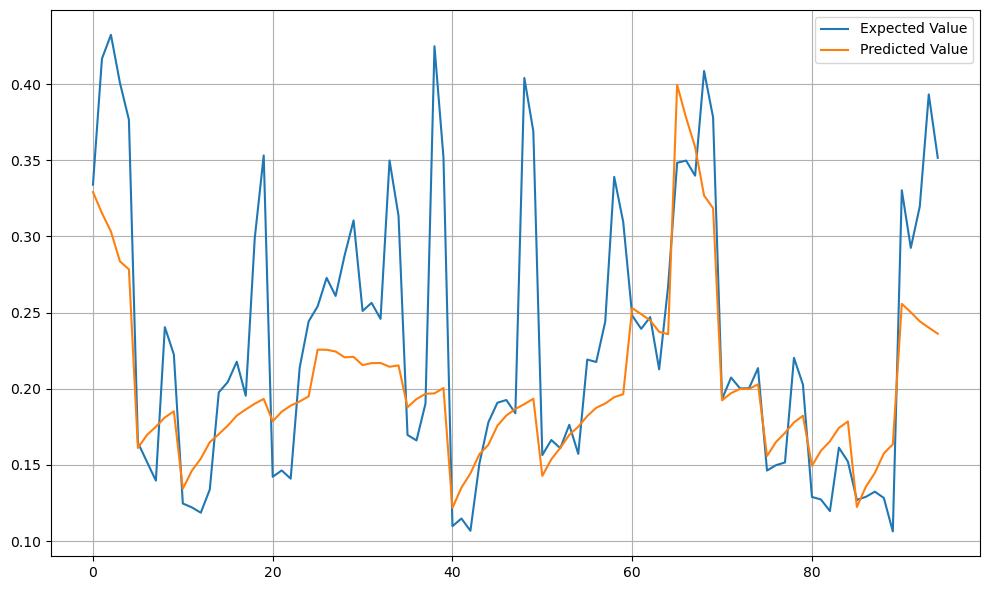


=== Training model: hidden=10, layers=2, dropout=0.001, lr=0.1 ===
Final Training Loss: 0.009188

Evaluating model performance...
Training RMSE: 0.10067179870278614
Training R2: 0.38687880070589487
Test RMSE: 0.06252249947902937
Test R2: 0.5212835658423409


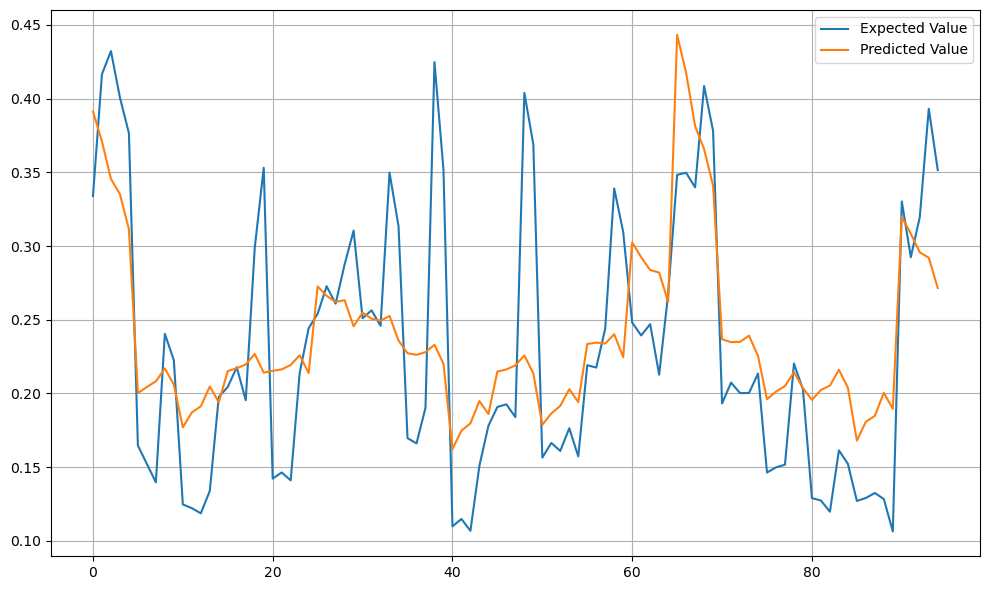


=== Training model: hidden=10, layers=3, dropout=0.001, lr=0.1 ===
Final Training Loss: 0.008612

Evaluating model performance...
Training RMSE: 0.09620739384774778
Training R2: 0.44005215622297245
Test RMSE: 0.08663612121944148
Test R2: 0.08081342174598172


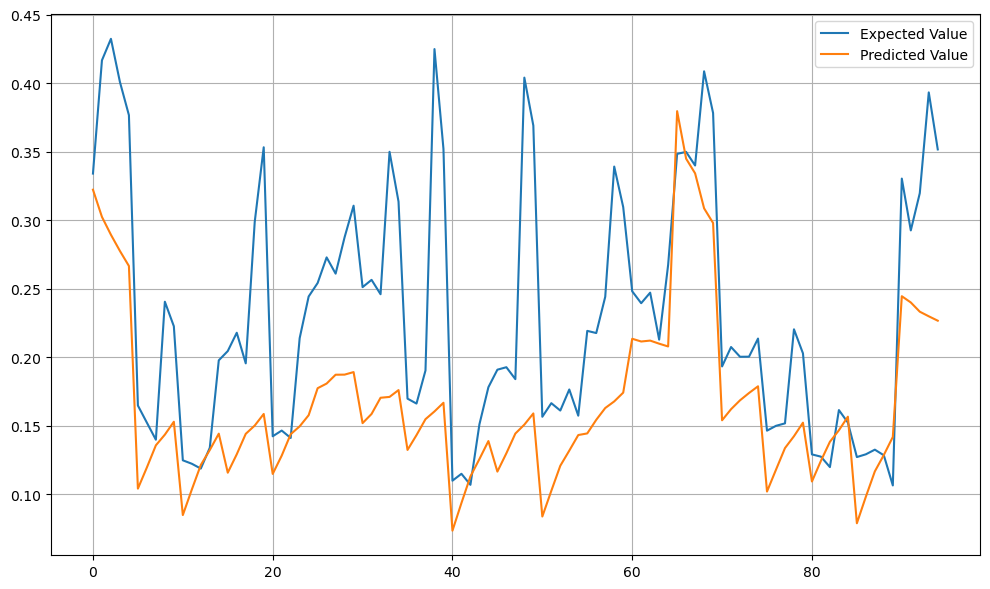


=== Training model: hidden=20, layers=1, dropout=0.001, lr=0.1 ===
Final Training Loss: 0.008834

Evaluating model performance...
Training RMSE: 0.09382614750129464
Training R2: 0.46742785821041355
Test RMSE: 0.06759506759931004
Test R2: 0.44045413961315094


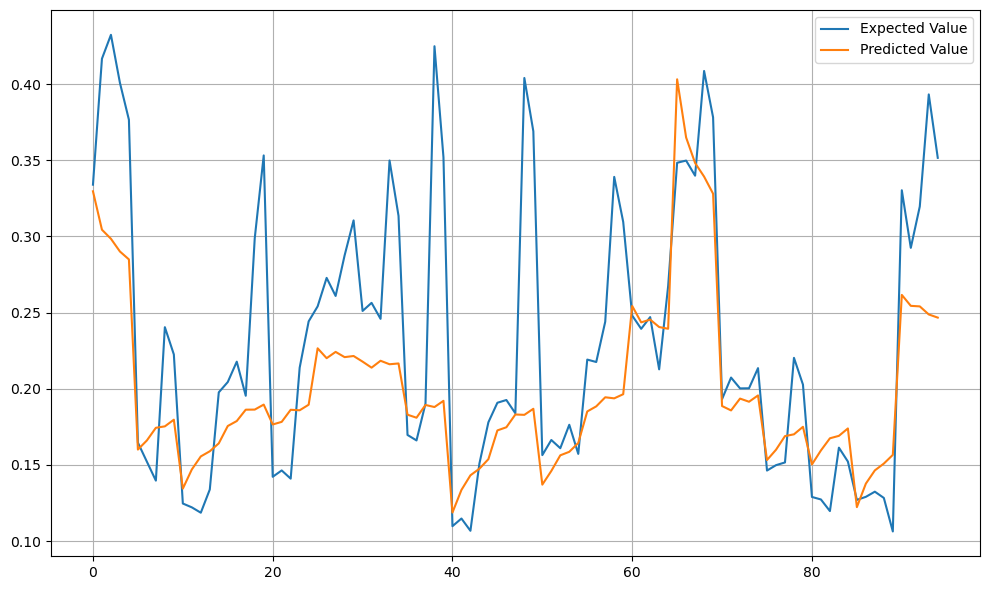


=== Training model: hidden=20, layers=2, dropout=0.001, lr=0.1 ===
Final Training Loss: 0.008950

Evaluating model performance...
Training RMSE: 0.09434770259551677
Training R2: 0.46149054255578614
Test RMSE: 0.06620692896312007
Test R2: 0.4631999340415536


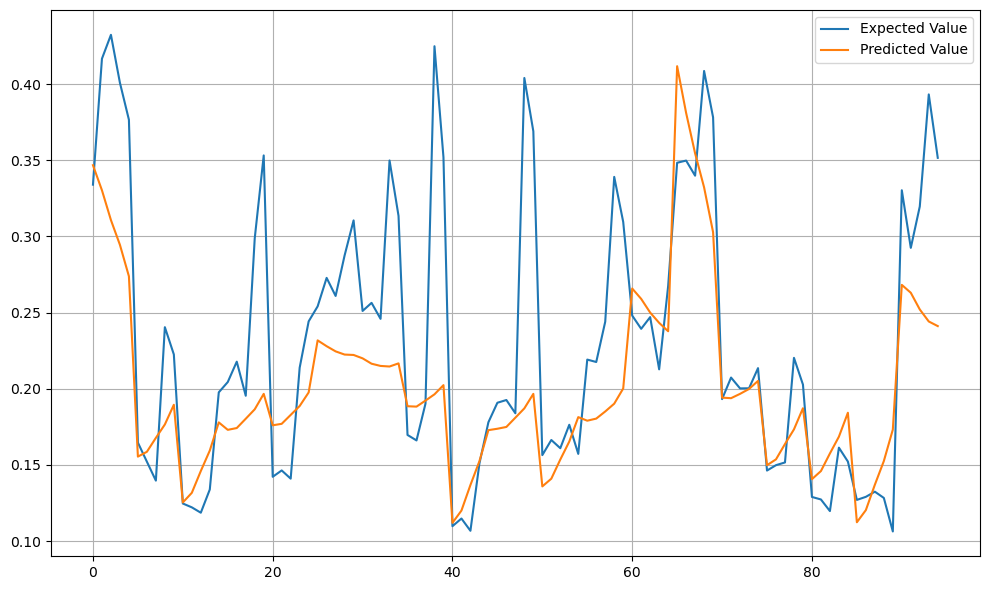


=== Training model: hidden=20, layers=3, dropout=0.001, lr=0.1 ===
Final Training Loss: 0.016530

Evaluating model performance...
Training RMSE: 0.12856787079143536
Training R2: 1.017880779596858e-05
Test RMSE: 0.09206034649506065
Test R2: -0.03788893993804687


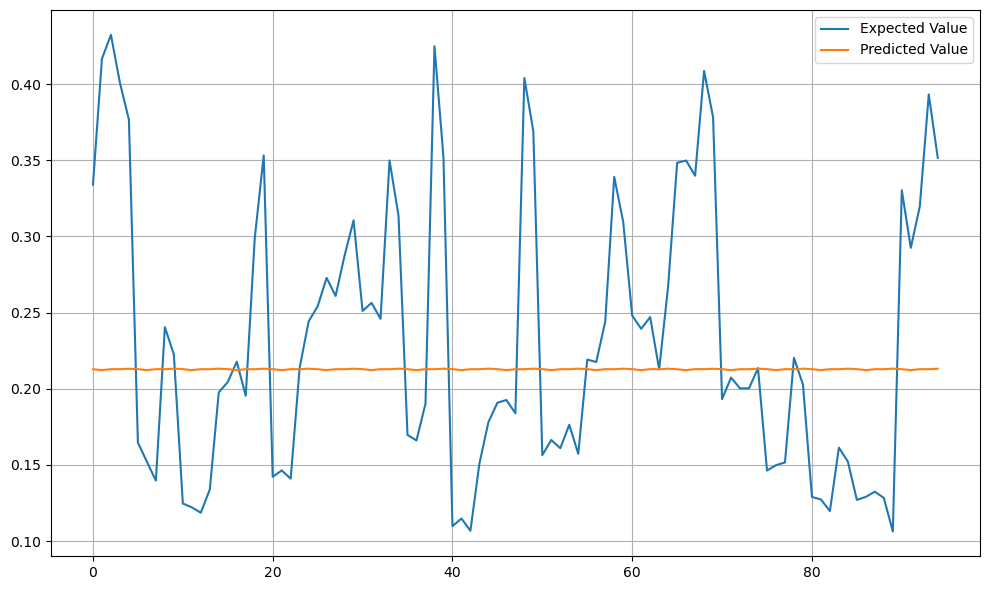


=== Training model: hidden=30, layers=1, dropout=0.001, lr=0.1 ===
Final Training Loss: 0.009179

Evaluating model performance...
Training RMSE: 0.09565603258810518
Training R2: 0.44645184891813594
Test RMSE: 0.06777684723959199
Test R2: 0.4374405820921555


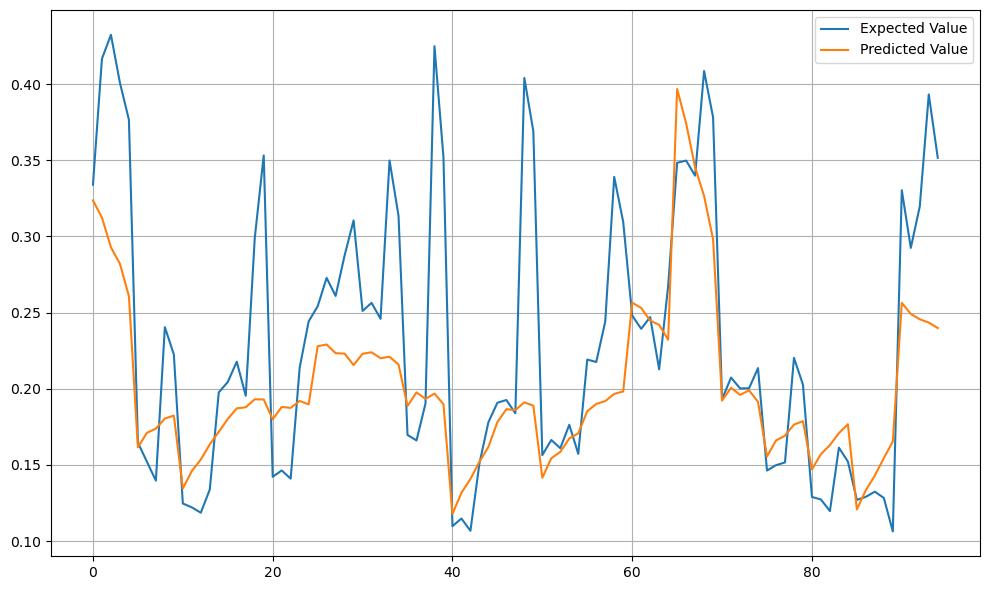


=== Training model: hidden=30, layers=2, dropout=0.001, lr=0.1 ===
Final Training Loss: 0.010601

Evaluating model performance...
Training RMSE: 0.10186945722267296
Training R2: 0.3722038320241907
Test RMSE: 0.066068632730741
Test R2: 0.4654401796612285


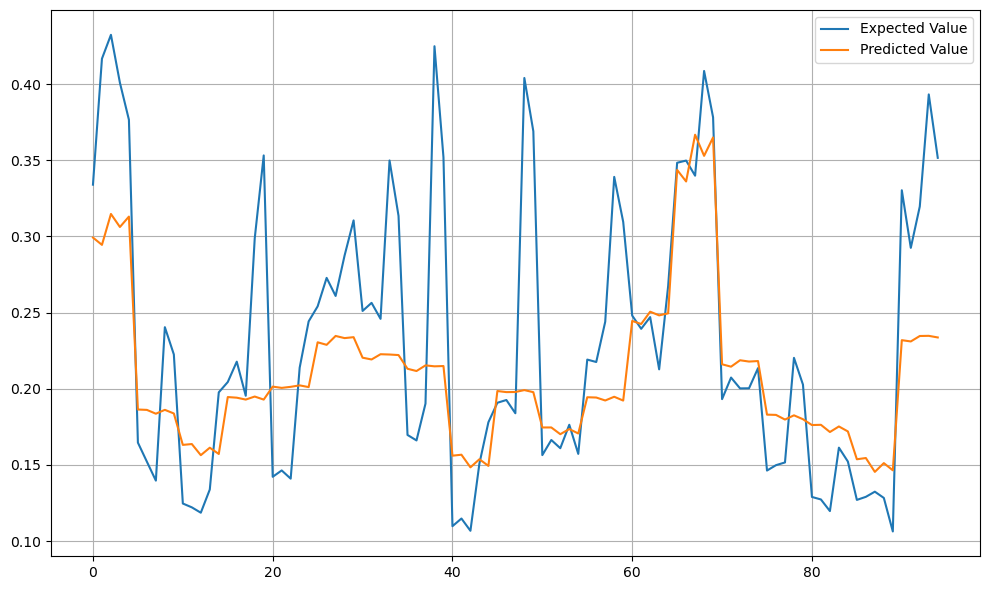


=== Training model: hidden=30, layers=3, dropout=0.001, lr=0.1 ===
Final Training Loss: 0.012284

Evaluating model performance...
Training RMSE: 0.10735802443586058
Training R2: 0.302732057724607
Test RMSE: 0.07374378895664246
Test R2: 0.33402708094178024


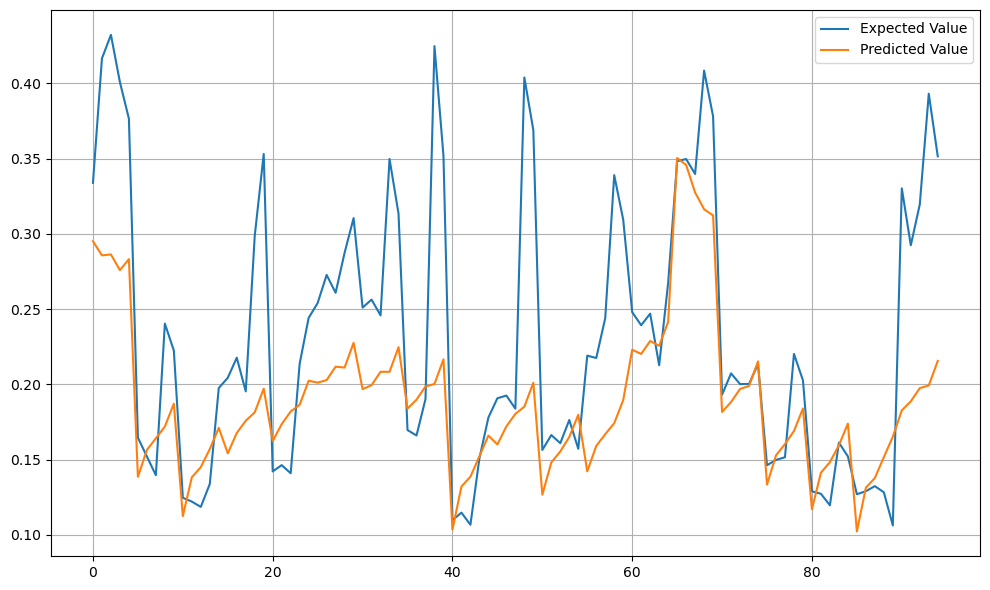


===== Best Model Summary =====
Hidden Size: 20
Num Layers: 1
Dropout: 0.001
Learning Rate: 0.1
Best RMSE: 0.093826


In [40]:
#hyperparameter tuning

#Grid of Parameters

num_features = X_5.shape[2]
output_size = y_5.shape[1]

# Hidden units: 
hidden_sizes = [s for s in range(10, 31, 10)]

# Layers: 
num_layers_list = [n for n in range(1, 4)]

# Dropout: 
dropout_probs = [0.001] #[round(p, 1) for p in np.arange(0.1, 0.4, 0.1)]

# Learning rates: 
learning_rates = [0.1] #[round(r, 3) for r in np.arange(0.001, 0.005, 0.001)]
results = []

best_mse = float("inf")
best_params = None
best_model = None

for hidden_size in hidden_sizes:
    for num_layers in num_layers_list:
        for dropout_prob in dropout_probs:
            for lr in learning_rates:

                print(f"\n=== Training model: hidden={hidden_size}, layers={num_layers}, dropout={dropout_prob}, lr={lr} ===")

                # Create model
                model = MyLSTMNet(
                    num_features=X_5.shape[2],
                    hidden_layer_size=hidden_size,
                    num_layers=num_layers,
                    output_size=y_5.shape[1],
                    dropout_prob=dropout_prob
                )

                # Define loss and optimizer
                criterion = nn.MSELoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                # Training loop
                num_epochs = 100
                for epoch in range(num_epochs):
                    model.train()
                    optimizer.zero_grad()
                    outputs = model(X_5, lengths_5)
                    loss = criterion(outputs, y_5)
                    loss.backward()
                    optimizer.step()

                print(f"Final Training Loss: {loss.item():.6f}")

                # Evaluate after training
                print("\nEvaluating model performance...")
                pred_eval(model, X_5, y_5, lengths_5, train_d_5, test_d_5, lookback=5, target_col=0)

                # Track best model by RMSE (test performance)
                model.eval()
                with torch.no_grad():
                    preds = model(X_5, lengths_5)
                    rmse = ((preds - y_5) ** 2).mean().sqrt().item()

                if rmse < best_mse:
                    best_mse = rmse
                    best_params = (hidden_size, num_layers, dropout_prob, lr)
                    best_model = model


print("\n===== Best Model Summary =====")
print(f"Hidden Size: {best_params[0]}")
print(f"Num Layers: {best_params[1]}")
print(f"Dropout: {best_params[2]}")
print(f"Learning Rate: {best_params[3]}")
print(f"Best RMSE: {best_mse:.6f}")


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split

def train_predict_model(model, n_epochs, lr, X_all, y_all, lengths, validation_split=0.2):
    batch_size = 32

    # Split data into train and validation sets
    dataset = TensorDataset(X_all, y_all, lengths)
    val_size = int(len(dataset) * validation_split)
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    print(f"The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")

    train_loss_history = []
    val_loss_history = []

    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch, lengths_batch in train_loader:
            y_pred = model(X_batch, lengths_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation check every 100 epochs
        if epoch % 100 == 0:
            model.eval()
            with torch.no_grad():
                train_preds = model(X_all[train_set.indices], lengths[train_set.indices])
                train_loss = loss_fn(train_preds, y_all[train_set.indices]).item()

                val_preds = model(X_all[val_set.indices], lengths[val_set.indices])
                val_loss = loss_fn(val_preds, y_all[val_set.indices]).item()

                print(f"Epoch {epoch+1}: train loss {train_loss:.4f}, val loss {val_loss:.4f}")

                train_loss_history.append(train_loss)
                val_loss_history.append(val_loss)

                # Save best model
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_state = model.state_dict()

    # Restore best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return train_loss_history, val_loss_history, model


In [47]:
def vis_train_loss(train_loss_history, val_loss_history):
    epochs = range(0, n_epochs, 100) 
    plt.plot(epochs, train_loss_history, label='Training Loss')
    plt.plot(epochs, val_loss_history, label='Validation Loss')  # <-- add this line
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Convergence')
    plt.legend()
    plt.grid()
    plt.show()

The model has 1,455 trainable parameters
Epoch 1: train loss 0.0156, val loss 0.0183
Epoch 101: train loss 0.0082, val loss 0.0095
Epoch 201: train loss 0.0080, val loss 0.0093
Epoch 301: train loss 0.0080, val loss 0.0093
Epoch 401: train loss 0.0079, val loss 0.0094
Epoch 501: train loss 0.0077, val loss 0.0094


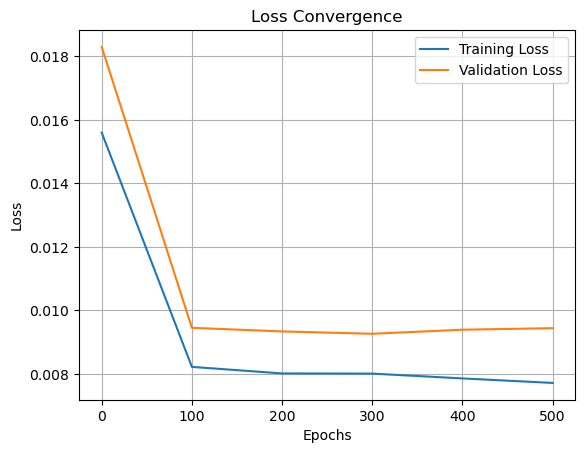

In [48]:
# Train a model using the best hyperparameters
# hidden=10, layers=2
num_features = X_5.shape[2]
hidden_layer_size = 10
output_size = test_steps
num_layers = 2
dropout_prob = 0.2

model_lstm_5 = MyLSTMNet(
    num_features=num_features,
    hidden_layer_size=hidden_layer_size,
    num_layers=num_layers,
    output_size=output_size,
    dropout_prob=dropout_prob
)

n_epochs = 501
lr = 0.001

train_loss_history_5, val_loss_history_5, model_lstm_5 = train_predict_model(
    model_lstm_5, n_epochs, lr, X_5, y_5, lengths_5, validation_split=0.2
)

#plotting epochs against loss

vis_train_loss(train_loss_history_5, val_loss_history_5)

Shape of input data after sequence creation: torch.Size([3501, 10, 1])
Shape of targets after sequence creation: torch.Size([3501, 5])

=== Training model: hidden=10, layers=1, dropout=0.1, lr=0.001 ===
Final Training Loss: 0.017848

Evaluating model performance...
Training RMSE: 0.1257520938802177
Training R2: 0.04333226620803665
Test RMSE: 0.08768939147599139
Test R2: 0.05832772003678233


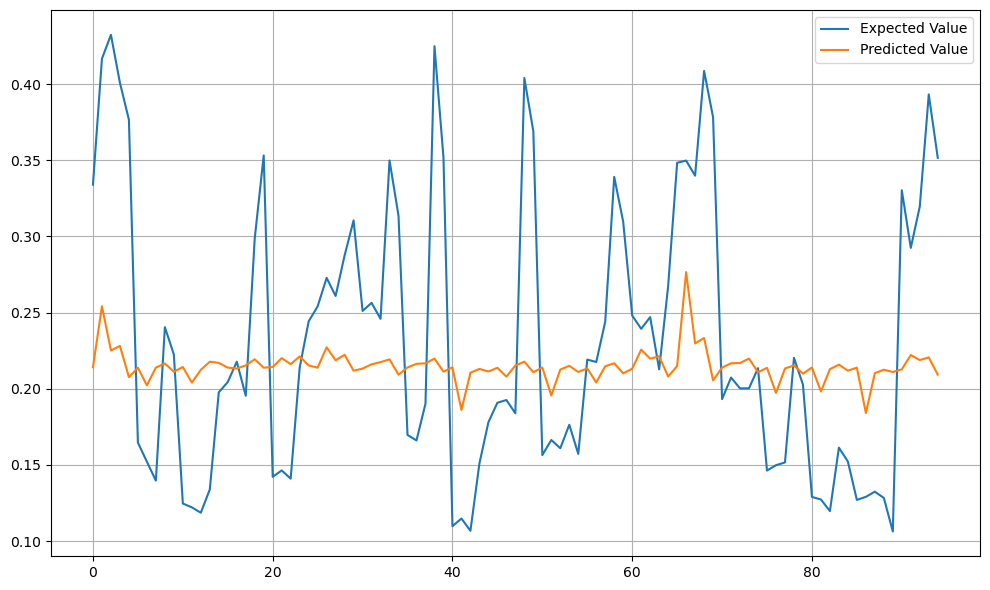


=== Training model: hidden=10, layers=2, dropout=0.1, lr=0.001 ===
Final Training Loss: 0.022588

Evaluating model performance...
Training RMSE: 0.1302278347887285
Training R2: -0.025978632166527182
Test RMSE: 0.09108618224222045
Test R2: -0.01603968890798768


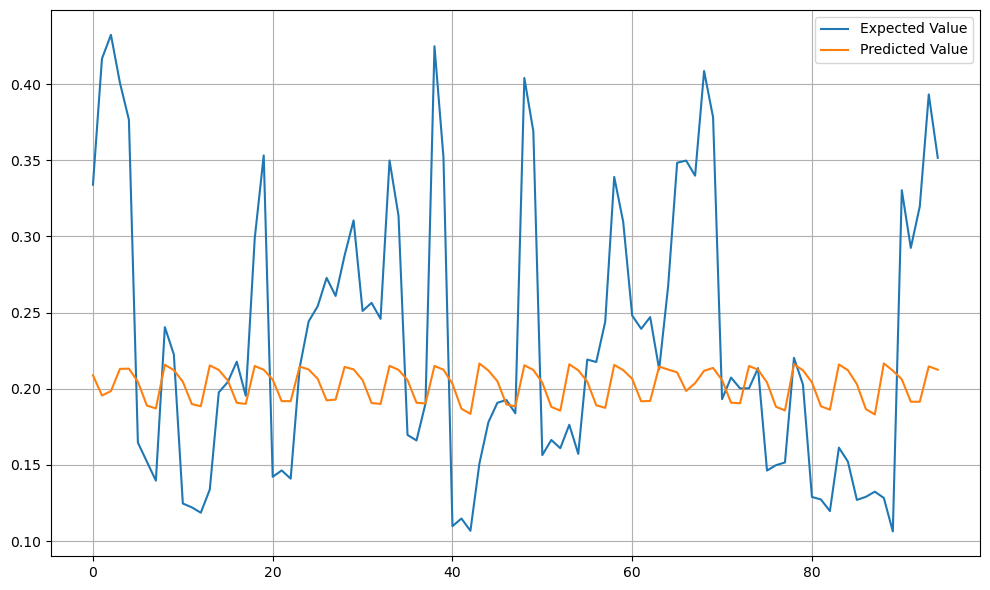


=== Training model: hidden=10, layers=3, dropout=0.1, lr=0.001 ===
Final Training Loss: 0.018223

Evaluating model performance...
Training RMSE: 0.12894986753153181
Training R2: -0.005940924402263903
Test RMSE: 0.0922352296416779
Test R2: -0.04183595281226049


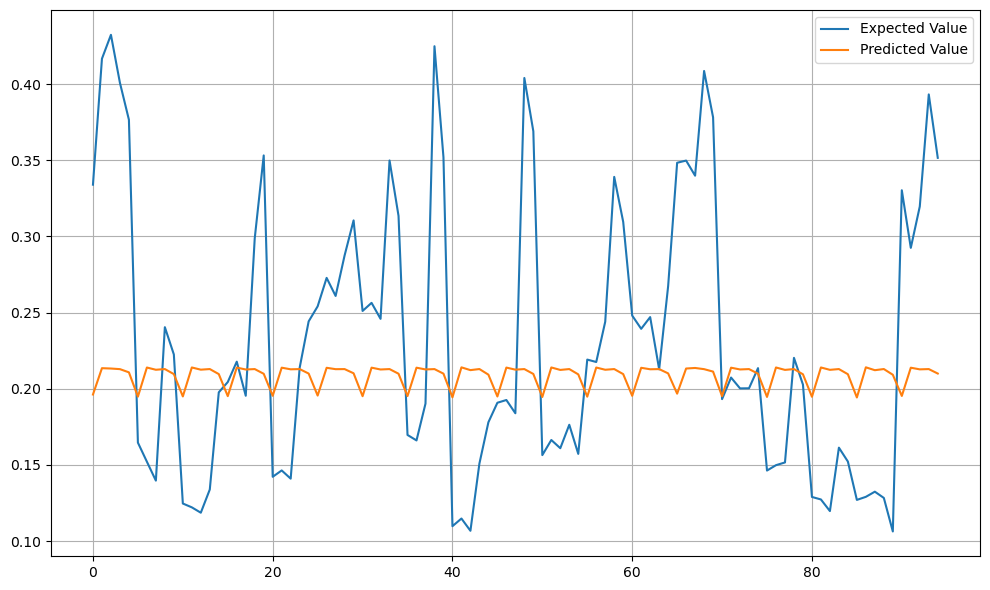


=== Training model: hidden=20, layers=1, dropout=0.1, lr=0.001 ===
Final Training Loss: 0.016432

Evaluating model performance...
Training RMSE: 0.12533769256638716
Training R2: 0.04962705042285376
Test RMSE: 0.0891201707102191
Test R2: 0.027347531901493194


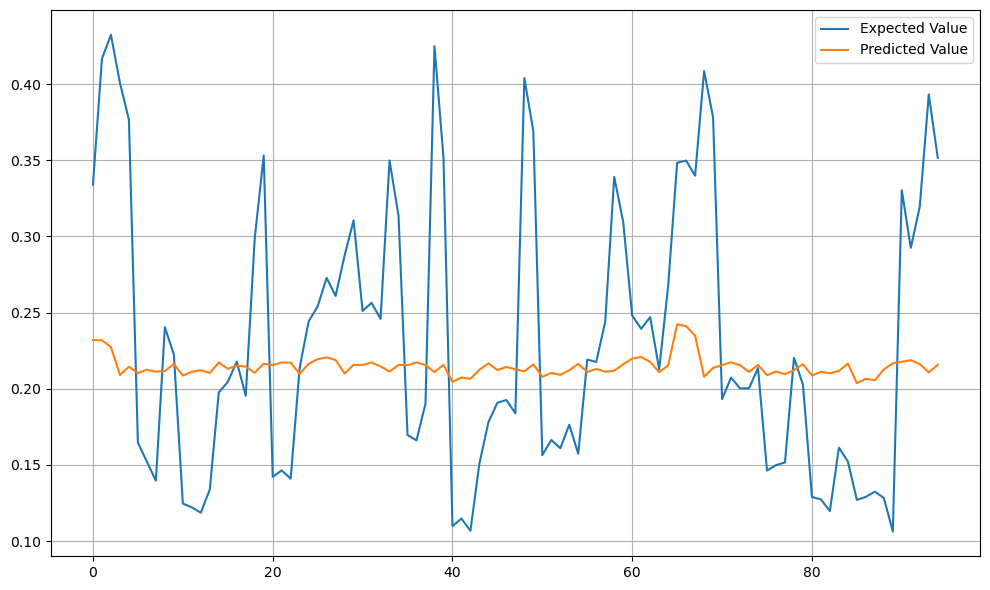


=== Training model: hidden=20, layers=2, dropout=0.1, lr=0.001 ===
Final Training Loss: 0.017084

Evaluating model performance...
Training RMSE: 0.1267881984829553
Training R2: 0.027502847822643228
Test RMSE: 0.09017149591797395
Test R2: 0.0042639682818153


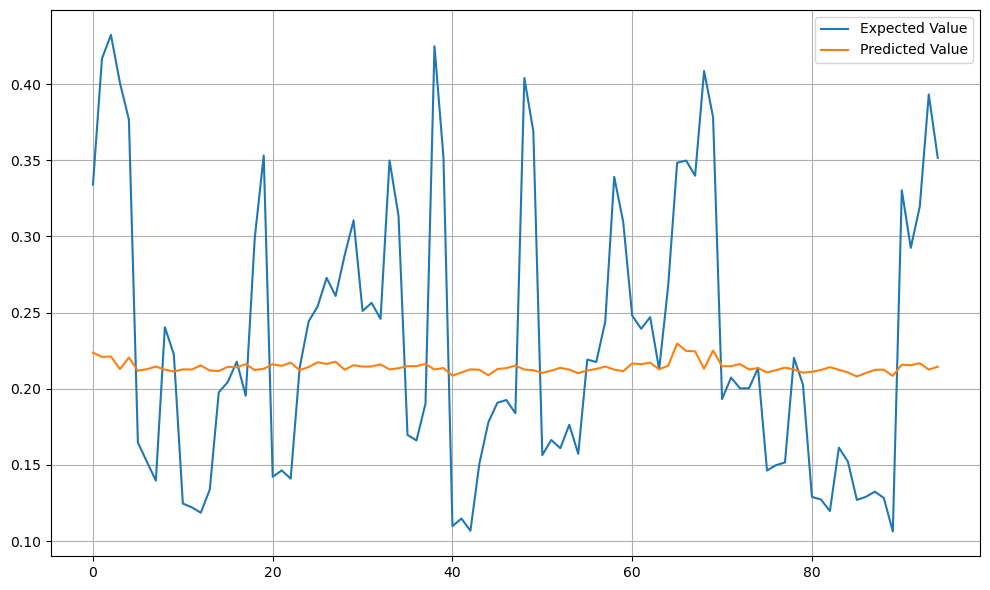


=== Training model: hidden=20, layers=3, dropout=0.1, lr=0.001 ===
Final Training Loss: 0.016773

Evaluating model performance...
Training RMSE: 0.12646773274556763
Training R2: 0.032412739436219695
Test RMSE: 0.08879045019841338
Test R2: 0.03453132001632697


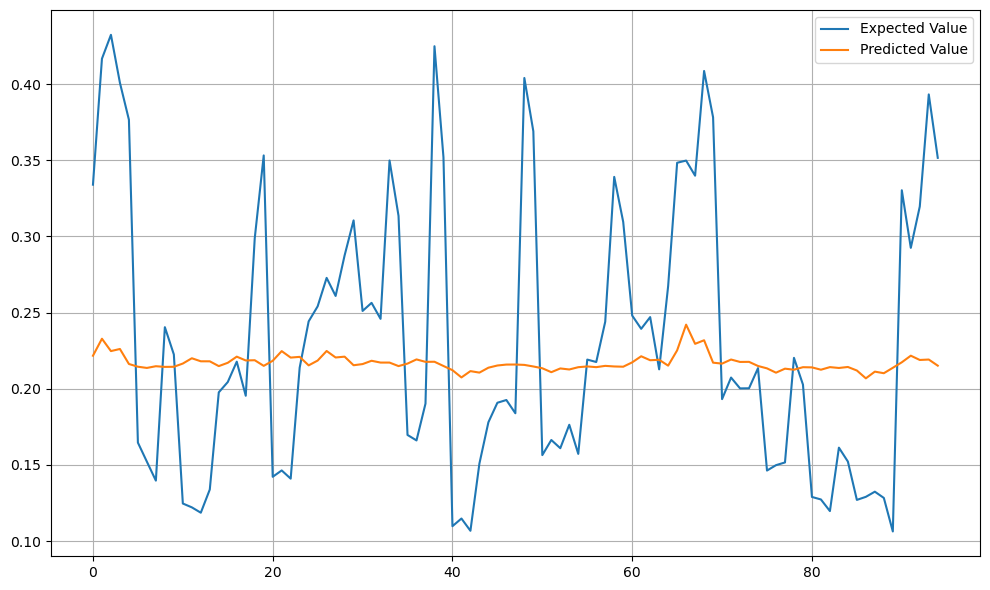


=== Training model: hidden=30, layers=1, dropout=0.1, lr=0.001 ===
Final Training Loss: 0.014832

Evaluating model performance...
Training RMSE: 0.11854273574858515
Training R2: 0.14987934610254572
Test RMSE: 0.08007382529570801
Test R2: 0.2147881845056463


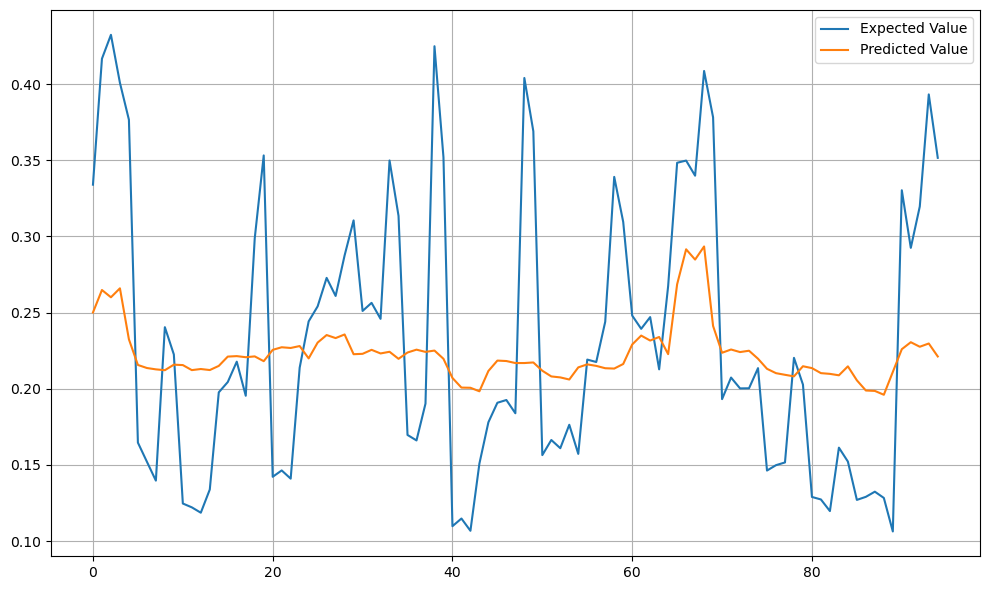


=== Training model: hidden=30, layers=2, dropout=0.1, lr=0.001 ===
Final Training Loss: 0.013558

Evaluating model performance...
Training RMSE: 0.1141947964555045
Training R2: 0.2110975485015223
Test RMSE: 0.08007011577678608
Test R2: 0.2148609346361161


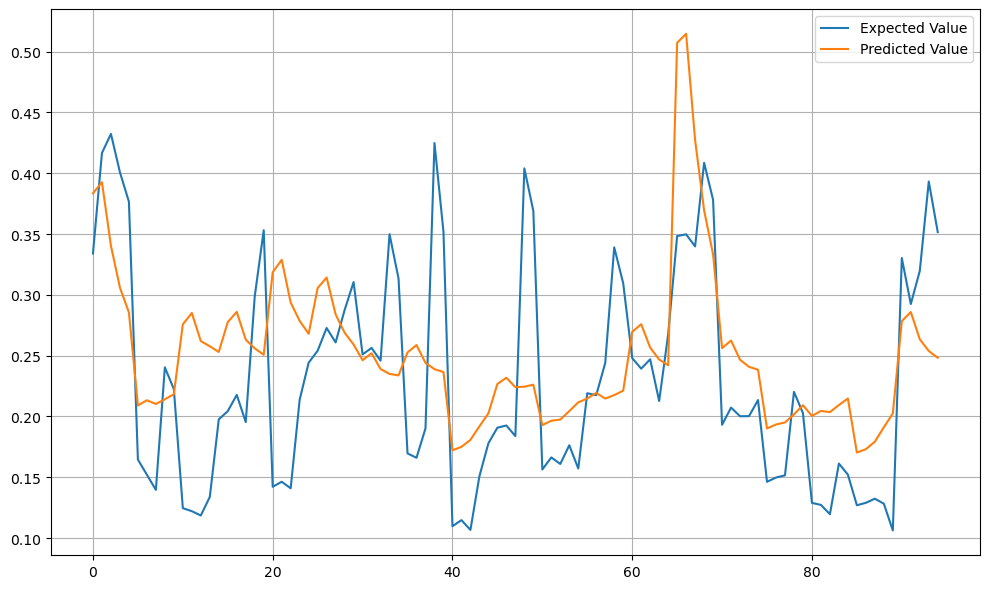


=== Training model: hidden=30, layers=3, dropout=0.1, lr=0.001 ===
Final Training Loss: 0.017433

Evaluating model performance...
Training RMSE: 0.12744849825512464
Training R2: 0.017347143206199345
Test RMSE: 0.08949586466497512
Test R2: 0.019129641858368185


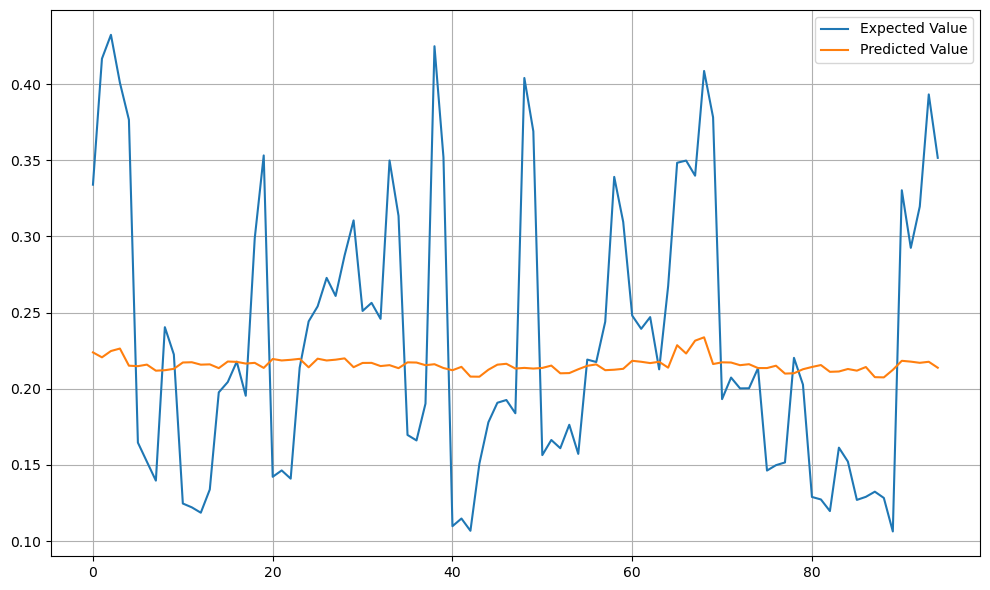


===== Best Model Summary =====
Hidden Size:   30
Num Layers:    2
Dropout:       0.1
Learning Rate: 0.001
Best RMSE:     0.114195


In [49]:
#Build another Univariate LSTM Model (Lookback = 10, Predict = 5).
#increase the lookback window


lookback = 10
test_steps = 5
target_col = 0

# Prepare data
X_10, y_10, lengths_10, train_d_10, test_d_10 = data_prep(tsdm_df, ['TSDM'], lookback, test_steps, target_col)
print("Shape of input data after sequence creation:", X_10.shape)
print("Shape of targets after sequence creation:", y_10.shape)

# --- Hyperparameter grid ---
num_features = X_10.shape[2]
output_size  = y_10.shape[1]

hidden_sizes    = [10, 20, 30]
num_layers_list = [1, 2, 3]
dropout_probs   = [0.1]
learning_rates  = [0.001]
results = []

best_mse   = float("inf")
best_params = None
best_model  = None

# --- Grid Search ---
for hidden_size in hidden_sizes:
    for num_layers in num_layers_list:
        for dropout_prob in dropout_probs:
            for lr in learning_rates:

                print(f"\n=== Training model: hidden={hidden_size}, layers={num_layers}, dropout={dropout_prob}, lr={lr} ===")

                model = MyLSTMNet(
                    num_features=num_features,
                    hidden_layer_size=hidden_size,
                    num_layers=num_layers,
                    output_size=output_size,
                    dropout_prob=dropout_prob
                )

                criterion = nn.MSELoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                num_epochs = 100
                for epoch in range(num_epochs):
                    model.train()
                    optimizer.zero_grad()
                    outputs = model(X_10, lengths_10)
                    loss = criterion(outputs, y_10)
                    loss.backward()
                    optimizer.step()

                print(f"Final Training Loss: {loss.item():.6f}")

                print("\nEvaluating model performance...")
                pred_eval(model, X_10, y_10, lengths_10, train_d_10, test_d_10, lookback=10, target_col=0)

                # --- Track best model ---
                model.eval()
                with torch.no_grad():
                    preds = model(X_10, lengths_10)
                    rmse = ((preds - y_10) ** 2).mean().sqrt().item()

                if rmse < best_mse:
                    best_mse   = rmse
                    best_params = (hidden_size, num_layers, dropout_prob, lr)
                    best_model  = model


print("\n===== Best Model Summary =====")
print(f"Hidden Size:   {best_params[0]}")
print(f"Num Layers:    {best_params[1]}")
print(f"Dropout:       {best_params[2]}")
print(f"Learning Rate: {best_params[3]}")
print(f"Best RMSE:     {best_mse:.6f}")


Shape of input data after sequence creation: torch.Size([3501, 10, 1])
Shape of targets after sequence creation: torch.Size([3501, 5])
The model has 11,555 trainable parameters
Epoch 1: train loss 0.0157, val loss 0.0160
Epoch 101: train loss 0.0078, val loss 0.0076
Epoch 201: train loss 0.0068, val loss 0.0075
Epoch 301: train loss 0.0051, val loss 0.0078
Epoch 401: train loss 0.0037, val loss 0.0078
Epoch 501: train loss 0.0028, val loss 0.0078


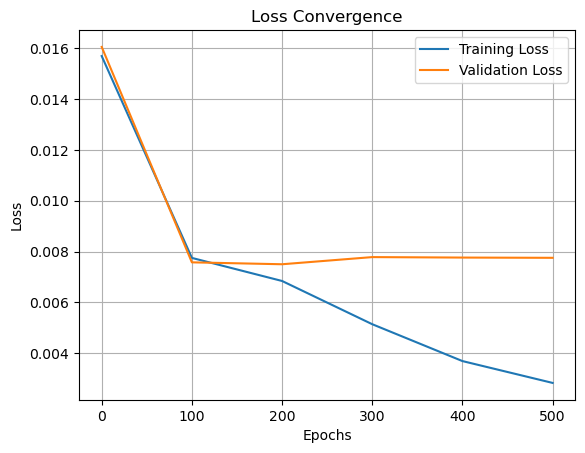

The model has 11,555 trainable parameters
Epoch 1: train loss 0.0037, val loss 0.0043
Epoch 101: train loss 0.0024, val loss 0.0057
Epoch 201: train loss 0.0021, val loss 0.0062
Epoch 301: train loss 0.0017, val loss 0.0067
Epoch 401: train loss 0.0014, val loss 0.0069
Epoch 501: train loss 0.0014, val loss 0.0065


In [53]:
# Train a model using the best hyperparameters for larger lookback
# hidden=30, layers=2
lookback = 10
test_steps = 5
target_col = 0

X_10, y_10, lengths_10, train_d_10, test_d_10 = data_prep(
    tsdm_df, ['TSDM'], lookback, test_steps, target_col
)

print("Shape of input data after sequence creation:", X_10.shape)
print("Shape of targets after sequence creation:", y_10.shape)

num_features = X_10.shape[2]
hidden_layer_size = 30
output_size = test_steps
num_layers = 2
dropout_prob = 0.2

model_lstm_10 = MyLSTMNet(
    num_features=num_features,
    hidden_layer_size=hidden_layer_size,
    num_layers=num_layers,
    output_size=output_size,
    dropout_prob=dropout_prob
)

train_loss_history_10, val_loss_history_10, model_lstm_10 = train_predict_model(
    model_lstm_10, n_epochs, lr, X_10, y_10, lengths_10, validation_split=0.2
)

#plotting epochs against loss

vis_train_loss(train_loss_history_10, val_loss_history_10)





n_epochs = 501
lr = 0.001

train_loss_history_10, val_loss_history_10, model_lstm_10 = train_predict_model(
    model_lstm_10, n_epochs, lr, X_10, y_10, lengths_10, validation_split=0.2
)


In [2]:
#Build a Multivariate LSTM Model. Use TSDM plus climate attributes as input features.

import numpy as np
import torch
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

def create_sequences_unfixed_lookback(sequence, lookback, forecast_horizon, target_col, pad_value=0.0):
    T, num_features = sequence.shape
    X, y, lengths = [], [], []

    if lookback > 0:
        # Fixed-length lookback with pre-padding
        pad_vector = np.zeros((lookback, num_features))

        for t in range(1, T - forecast_horizon + 1):
            context = sequence[:t]
            if len(context) > lookback:
                context = context[-lookback:]

            padded_context = pad_vector.copy()
            padded_context[-len(context):] = context

            X.append(padded_context)
            y.append(sequence[t:t + forecast_horizon, target_col])
            lengths.append(min(len(context), lookback))

        return np.array(X), np.array(y), lengths

    else:
        # Full history with left pre-padding (variable-length inputs)
        for t in range(1, T - forecast_horizon + 1):
            context = torch.tensor(sequence[:t], dtype=torch.float32)
            lengths.append(t)

            X.append(context)  # No manual padding
            y.append(torch.tensor(sequence[t:t + forecast_horizon, target_col], dtype=torch.float32))

        X_padded = pad_sequence(X, batch_first=True, padding_value=pad_value)
        y_tensor = torch.stack(y)

        return X_padded.numpy(), y_tensor.numpy(), lengths

In [14]:
print(tsdm_df.columns)

Index(['PADDOCK_ID', 'OBSERVATION_DATE', 'TSDM', '15D_AVG_DAILY_RAIN',
       '15D_AVG_MAX_TEMP', '15D_AVG_MIN_TEMP', '15D_AVG_RH_TMAX',
       '15D_AVG_RH_TMIN', '15D_AVG_EVAP_SYN', '15D_AVG_RADIATION'],
      dtype='object')


In [4]:
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

def data_prep_unfixed_lookback(df, feature_columns, lookback, test_steps, target_col):
    # Prepare to store all training data
    X_all, y_all, lengths_all = [], [], []
    location_ids = []
    test_data, train_data = [], []

    # Fit a global scaler on all paddocks' training portions
    all_train_values = []
    for _, group in df.groupby("PADDOCK_ID"):
        feature_values = group[feature_columns].values
        if len(feature_values) > lookback + test_steps:
            all_train_values.append(feature_values[:-test_steps])

    if not all_train_values:
        raise ValueError("No paddocks have enough data for scaling. Reduce lookback/test_steps.")

    all_train_values = np.vstack(all_train_values)
    global_scaler = MinMaxScaler()
    global_scaler.fit(all_train_values)

    # Process each paddock
    for location_id, group in df.groupby("PADDOCK_ID"):
        feature_values = group[feature_columns].values
        min_required = lookback + test_steps
        if len(feature_values) <= min_required:
            continue

        # Scale and split
        train_sample = global_scaler.transform(feature_values[:-test_steps])
        test_sample = global_scaler.transform(feature_values[-test_steps:])
        train_data.append((location_id, train_sample))
        test_data.append((location_id, test_sample, global_scaler))

        # Create sequences
        X_location, y_location, lengths = create_sequences_unfixed_lookback(
            train_sample, lookback, test_steps, target_col
        )

        # Collect
        X_all.append(X_location)
        y_all.append(y_location)
        lengths_all.append(lengths)
        location_ids.extend([location_id] * len(y_location))

    # Handle empty case
    if not X_all:
        raise ValueError(
            f"No paddocks produced valid sequences. "
            f"Check lookback={lookback} and test_steps={test_steps}."
        )

    # Truncate to shortest paddock sequence length
    min_len = min(x.shape[1] for x in X_all)
    num_features = X_all[0].shape[2]

    X_truncated = []
    for x in X_all:
        x_trunc = x[:, -min_len:, :]  # keep last min_len timesteps
        X_truncated.append(x_trunc)

    # Concatenate across paddocks
    X_all = np.concatenate(X_truncated, axis=0)
    y_all = np.concatenate(y_all, axis=0)
    lengths_all = np.concatenate(lengths_all, axis=0)

    # Sanity reshape
    X_all = X_all.reshape((X_all.shape[0], X_all.shape[1], X_all.shape[2]))

    # Return tensors
    return (
        torch.Tensor(X_all),
        torch.Tensor(y_all),
        torch.Tensor(lengths_all),
        train_data,
        test_data,
    )





In [5]:
def train_predict_model_unfixed_lookback(model, n_epochs, lr, X_all, y_all, lengths, validation_split=0.2):
    batch_size = 32

    lengths = torch.clamp(lengths, max=X_all.shape[1])


    # Split data into train and validation sets
    dataset = TensorDataset(X_all, y_all, lengths)
    val_size = int(len(dataset) * validation_split)
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    print(f"The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")

    train_loss_history = []
    val_loss_history = []

    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch, lengths_batch in train_loader:
            y_pred = model(X_batch, lengths_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation check every 100 epochs
        if epoch % 100 == 0:
            model.eval()
            with torch.no_grad():
                #Convert indices to tensors before indexing
                train_idx = torch.tensor(train_set.indices, dtype=torch.long)
                val_idx = torch.tensor(val_set.indices, dtype=torch.long)

                train_preds = model(X_all[train_idx], lengths[train_idx])
                train_loss = loss_fn(train_preds, y_all[train_idx]).item()

                val_preds = model(X_all[val_idx], lengths[val_idx])
                val_loss = loss_fn(val_preds, y_all[val_idx]).item()

                print(f"Epoch {epoch+1}: train loss {train_loss:.4f}, val loss {val_loss:.4f}")

                train_loss_history.append(train_loss)
                val_loss_history.append(val_loss)

                # Save best model
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_state = model.state_dict()

    # Restore best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return train_loss_history, val_loss_history, model


In [8]:
lookback = 0 # no restriction of lookback
target_col = 1
test_steps = 5

X_f, y_f,lengths_f, train_d_f, test_d_f = data_prep_unfixed_lookback(tsdm_df,['TSDM','15D_AVG_DAILY_RAIN',
       '15D_AVG_MAX_TEMP', '15D_AVG_MIN_TEMP', '15D_AVG_RH_TMAX',
       '15D_AVG_RH_TMIN', '15D_AVG_EVAP_SYN', '15D_AVG_RADIATION'],lookback,test_steps, target_col)

print("Shape of input data after sequence creation:", X_f.shape)
print("Shape of targets after sequence creation:", y_f.shape)



Shape of input data after sequence creation: torch.Size([3501, 183, 8])
Shape of targets after sequence creation: torch.Size([3501, 5])


In [16]:
num_features = X_f.shape[2]
hidden_layer_size = 10
output_size = test_steps
n_epochs = 501
lr = 0.001
num_layers = 2
dropout_prob = 0.2
model_lstm_f = MyLSTMNet(num_features, hidden_layer_size, num_layers, output_size,dropout_prob)

train_loss_history_f,val_loss_history_f,model_lstm_f = train_predict_model_unfixed_lookback(model_lstm_f, n_epochs, 
                                                                           lr, X_f, y_f, lengths_f, 
                                                                           validation_split=0.2)

pred_eval(model_lstm_f, X_f, y_f, lengths_f, train_d_f, test_d_f, lookback, target_col)

The model has 1,735 trainable parameters
Epoch 1: train loss 0.0233, val loss 0.0226


KeyboardInterrupt: 

In [ ]:
vis_train_loss(train_loss_history_f, val_loss_history_f)

NameError: name 'train_loss_history_f' is not defined